# Poly(2-Ethyl-2-oxazoline) - API in water

TODO:  Simplify everything using OEChem 

In [39]:
#Modules to import

from sys import stdout
import time
import requests
from openbabel import openbabel,pybel
from simtk.openmm import app
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
from openmmforcefields.generators import SystemGenerator
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmoltools import packmol
import numpy as np
import nglview
import ipywidgets
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import pandas as pd

## Generate all input files

In theory this should only be done ones.

### Building a polymer

OpenEye

https://github.com/openforcefield/open-forcefield-tools/blob/master/openforcefield/substances.py
https://github.com/openforcefield/open-forcefield-tools/blob/master/examples/substructure_linking.ipynb

RDkit

https://www.rdkit.org/docs/RDKit_Book.html
https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/003_SMARTS_ReactionsExamples.ipynb

Smiles

This is The easiest way, if the polymer is fairly simple. If Cross-linking occurs this becomes far from trivial.

In [16]:
# Smiles codes

initiator = "C"
unit = "N(C(=O)CC)CC"
terminator = "C"
number_of_units = 10

polymer = initiator + number_of_units*unit + terminator
polymer_filename= f'polymer_{number_of_units}units'


#Conversion to PDB
mol = pybel.readstring('smi',polymer)
mol.make3D()
print(mol.write('pdb',f"{polymer_filename}.pdb",overwrite=True))

#from smile to format x codes gen3d option is needed, command line: obabel -i stdin -o out.pdb --gen3d <<< "CC"

### Possibly this should be converted towards other formats as well.
#generate sdf file and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
mol = openbabel.OBMol()
obConversion.SetInAndOutFormats("pdb", "sdf")
obConversion.ReadFile(mol, f"{polymer_filename}.pdb")
obConversion.WriteFile(mol, f"{polymer_filename}.sdf")

#For some reason this conversion can not be used in the openforcefield...

#Visualize the generated polymer
nglview.show_file(f"polymer_{number_of_units}units.pdb")

None


NGLWidget()

In [13]:
from openeye import oechem
initiator = "C"
unit = "N(C(=O)CC)CC"
terminator = "C"
number_of_units = 50

polymer = initiator + number_of_units*unit + terminator
polymer_filename= f'polymer_{number_of_units}units'

mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, polymer)
print("Number of phenol atoms:", mol.NumAtoms())
out=oechem.oemolostream(polymer_filename+'.pdb')
oechem.OEWriteMolecule(out, mol)

#no 3D coordinates are added


Number of phenol atoms: 352


0

### Collect the Active Farmaceutical ingrediënt (API)

In [7]:
# API
api_cid = ['35802']

#generate sdf file and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()

# Convert to pdb file and generate a smiles string
for cid in api_cid:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"API_{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"API_{cid}.sdf")
    obConversion.WriteFile(mol, f"API_{cid}.pdb")
api_smiles = Molecule.from_file(f"API_{cid}.sdf").to_smiles()



### Generate the water molecule

This should comply with the format needed for the forcefield which you will use typically tip3p(fb) type of forcefields. Hence atom types should match.

In [ ]:
#Water molecule

water_smiles = 'O'

#Conversion to PDB
wat = pybel.readstring('smi',water_smiles)
wat.make3D()
#put overwrite to False once the created file is in the correct format
wat.write('pdb',f"water.pdb",overwrite=True)

md_traj_water = md.load("water.pdb")
if packmol.standardize_water(md_traj_water):
    print('Water molecule already had correct format')
else: print('The water_pdbFile should be adjusted: 3 atoms 1 residue, ADJUST_MANUALY')
print(md_traj_water)
packmol.rename_water_atoms('water.pdb')


## Using OpenEye
#mol = oechem.OEMol()
#oechem.OESmilesToMol(mol, 'O')
#oechem.OEAddExplicitHydrogens(mol)
#oechem.OETriposAtomNames(mol)
#mols.append(mol)


## Calculate the initial box size and number of water molecules

Implement a Simple method to calculate the desired boxsize. e.g. minimal volume = sum of all vdw spheres. paste them all behind each other could be the maximal.


From geometry in numpy array, calculate longest distance? add extra solvent layers. I believe this is the simplest way and most convenient.
370 + 2*5 = 380 A this is longest possible distance for the cube... hence determine box dimension based hereon.. calculate initial number of water molecules based on this box size and the experimental density at these conditions...


## Parameterizing all components

### AmberTools

Alternatively to the OpenFF approach, AmberTools could be used for generating the forcefield.
One can however look at OpenFF as a clean and user-friendly approach of gaff (generalized amber forcefield) this is hence a prefered way to parameterize everything.

https://ambermd.org/tutorials/advanced/tutorial27/pet.html



### OpenFF
TODO ADD some explenations

### API parameterization

In [8]:
#Forcefield     
off_forcefield = ForceField('openff-1.0.0.offxml')

#parameterization
uniq_molecules = [Molecule.from_file(f"API_{api_cid[0]}.sdf")]
api_pdb = PDBFile(f"API_{api_cid[0]}.pdb")
api_positions =  api_pdb.getPositions()
off_api_topology = Topology.from_openmm(api_pdb.topology,unique_molecules=uniq_molecules)
off_api_system = off_forcefield.create_openmm_system(off_api_topology)


/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3  O   UNL     1       6.202   1.839   0.002  1.00  0.00           O  , HETATM    2  O   UNL     1      -3.211  -2.659   0.001  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    4  O   UNL     1       5.839  -0.416  -0.001  1.00  0.00           O  , HETATM    3  O   UNL     1       6.202   1.839   0.002  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

#### Visualize the molecule

In [ ]:
nglview.show_file(f"API_{api_cid[0]}.pdb")

#### Energy minimization

To check whether the generated forcefield can actually be used.

In [ ]:

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_api_system, integrator)
context.setPositions(api_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

### Polymer parameterization

#### Polymer = one molecule

In [17]:
from openforcefield.utils.toolkits import ToolkitRegistry, OpenEyeToolkitWrapper, RDKitToolkitWrapper, AmberToolsToolkitWrapper

toolkit_registry = ToolkitRegistry()
toolkit_registry.register_toolkit(RDKitToolkitWrapper)

#Forcefield     
off_forcefield = ForceField('openff-1.0.0.offxml')

#parameterization

polymer = PDBFile(f"{polymer_filename}.pdb")
polymer_positions =  polymer.getPositions()
uniq_molecules = [Molecule.from_file(f"{polymer_filename}.sdf")]
#If OpenEye is available, multiple formats can be used to create the unique molecules.
off_polymer_topology = Topology.from_openmm(polymer.topology,unique_molecules=uniq_molecules)
off_polymer_system = off_forcefield.create_openmm_system(off_polymer_topology,toolkit_registry=toolkit_registry)


#Problem with charges: https://github.com/openforcefield/openforcefield/issues/346, I believe this is a problem occuring in OEchem toolkit, solve by using RD toolkit

/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3  C   UNL     1       3.243  -0.900   1.005  1.00  0.00           C  , HETATM    1  C   UNL     1       1.061  -0.002   0.067  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    5  C   UNL     1       2.463  -1.783   1.927  1.00  0.00           C  , HETATM    3  C   UNL     1       3.243  -0.900   1.005  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

#### Energy minimization

To check whether the generated forcefield can actually be used.

In [ ]:

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_polymer_system, integrator)
context.setPositions(polymer_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

#### Polymer parameterized by 3 different Units? 

Probably this is not needed
TODO   https://github.com/openforcefield/open-forcefield-tools/blob/master/examples/substructure_linking.ipynb

## Polymer-water solvent box

Multiple approaches are available to constuct a solvent box:
1. Packmol (openmoltools)
2. OpenMM modeller (https://github.com/openmm/openmmforcefields)
3. leap (Ambertools)
4. openforcefield-tools (Property calculation toolkit requires OpenEye licence) https://github.com/openforcefield/openforcefield/issues/66
https://github.com/slochower/smirnoff-host-guest/blob/3a319972d5b6fded1784eaad75d6bf5e754343a3/mol2-to-prmtop.ipynb;https://github.com/MobleyLab/SolvationToolkit

Following packages should be installed:

1. Packmol 
2. openmoltools
3. mdtraj 
4. SolvationToolkit (openeye)


git clone https://github.com/MobleyLab/SolvationToolkit.git
cd SolvationToolkit
pip install .

https://github.com/openforcefield/openforcefield/blob/master/examples/using_smirnoff_with_amber_protein_forcefield/toluene_in_T4_lysozyme.ipynb
https://github.com/openforcefield/openforcefield/blob/master/examples/using_smirnoff_in_amber_or_gromacs/convert_to_amber_gromacs.ipynb

#### OpenmolTools

I have manually adjusted the packmol.py file (in ~/anaconda3/envs/openmm/lib/python3.7/site-packages/openmoltools) as the bonds were defined as an array of 1 x 4 ; at line 196 insert the code snippet below
but in this case the bond type and order should be in the 3rd and fourth column, this is however not the case.
there for this is put to zero at the end which corresponds to a bond order and type of None, though antechambers
will put this correct normally based on the bonds. Alternatively n_atoms is added after each molecule 
to bonds_i [0] and [1] instead to avoid a potential loss of information.
'''
    #cast atom type and order to 0
    if len(bonds[0])==4:
        for idx,frame in enumerate(bonds):
               bonds[idx][2] = 0
               bonds[idx][3] = 0

The following part is also incorrect as it does not work when loading it from smiles etc... manually adjusted pdb to show 3 residues
    #Find waters and rename
    for residue in pdb.residues:
        if len(residue)==3:
 

TODO: Report to openmoltools Done

In [4]:
# Create water box with openmoltools

#possibly polymer_filename etc should be reinitialized

polymer_smiles = Molecule.from_file(f"{polymer_filename}.sdf").to_smiles() #easier as oechem object
water_smiles = 'O'

pdb_filenames = [f"{polymer_filename}.pdb" , "water.pdb"]

#TODO Determine dynamically the number of solvent molecules needed (min/max) (see above)
n_molecules = [1,1000]

if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([polymer_smiles,water_smiles],n_molecules)
else:
    box_size = 40.0
    
# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')


# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmptbgg2ui9/tmpw4r720gn.pdb
add_amber_ter


structure polymer_50units.pdb
  number 1 
  inside box 0. 0. 0. 61.864296 61.864296 61.864296
end structure

structure water.pdb
  number 1000 
  inside box 0. 0. 0. 61.864296 61.864296 61.864296
end structure



OSError: No such file: /tmp/tmptbgg2ui9/tmpw4r720gn.pdb

#### Solvationtoolkit (openEye)

In [ ]:
# Create water box with Solvationtoolkit  (OEChem)
#TODO Test


from solvationtoolkit.solvated_mixtures import *

polymer_molecule = Molecule.from_file(f"{polymer_filename}.sdf")
mixture = MixtureSystem()

#TODO generate method to determine number of water molecules

mixture.addComponent(label='pethox',smiles=polymer_molecule.to_smiles(), number=1)
mixture.addComponent('water',number=10000)  #this is tip3p format (similar to tip3pfb???)
mixture.build()



#### Using the modeller from in OpenMM

At the moment this feature in not usable ... yet

In [ ]:
# Create water box in OpenMM by constructing a modeller object starting from the pdb file. 
'https://github.com/openmm/openmmforcefields/blob/master/openmmforcefields/generators/system_generators.py'
#polymer = PDBFile(f"{polymer_filename}.pdb")
'''polymer_structure = pmd.openmm.load_topology(polymer.topology,off_polymer_system,xyz=polymer.positions)
polymer_structure.write_pdb(f"{polymer_filename}_converted.pdb")
polymer_converted = PDBFile(f"{polymer_filename}_converted.pdb")
#alternatively gaff forcefields can be used.
obConversion.SetInAndOutFormats("pdb", "sdf")
obConversion.ReadFile(mol, f"{polymer_filename}_converted.pdb")
obConversion.WriteFile(mol, f"{polymer_filename}_converted.sdf")
not needed 
'''
polymer_molecule = Molecule.from_file(f"{polymer_filename}.sdf") #_converted.sdf")
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
smirnoff = SMIRNOFFTemplateGenerator(molecules=[polymer_molecule])
#smirnoff.add_molecules(polymer_molecule)
omm_forcefield = app.ForceField('tip3p.xml')
#add forcefield file for the polymer constructed with openff using openmmforcefields.generators
omm_forcefield.registerTemplateGenerator(smirnoff.generator)

polymer_modeller = Modeller(#(polymer_converted.topology, polymer_converted.positions)
#polymer_modeller.addSolvent(forcefield, model='tip3pfb',NumAdded=5000) 
polymer_modeller.addSolvent(omm_forcefield, model='tip3p', padding=0.5*nanometers) 
#This determines the largest size of the solute along any axis (x, y, or z). It then creates a cubic box of width (solute size)+2*(padding). The above line guarantees that no part of the solute comes closer than 1 nm to any edge of the box.

#### Conversion to amber forcefield

In [ ]:
''' Conversion to Amber file format
import parmed as pmd
#I believe this is accompagnied with a loss of information?
polymer_structure = pmd.openmm.load_topology(polymer.topology,off_polymer_system,xyz=polymer.positions)
print(polymer_structure)

# Export AMBER files.
polymer_structure.save('system.inpcrd', overwrite=True)

#This is a work-around around a certain problem within parmed... This issue was reported before see:
#'https://github.com/slochower/smirnoff-host-guest/blob/3a319972d5b6fded1784eaad75d6bf5e754343a3/mol2-to-prmtop.ipynb'
bond_type = pmd.BondType(1.0, 1.0, list=polymer_structure.bond_types)
polymer_structure.bond_types.append(bond_type)
for bond in polymer_structure.bonds:
    if bond.type is None:
        bond.type = bond_type
polymer_structure.save('system.prmtop', overwrite=True)
'''

##### Visualize the molecule

In [ ]:

t = md.load(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')
print(t)
w = nglview.show_mdtraj(t)
#nglview.show_file(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')
w.add_representation('ball+stick',selection='water')
w


### Parameterize solvent box

To use a barostat, you need to define a barostat whose parameters will be copied into each system (with a different random number seed):

```python
pressure = 1.0 * unit.atmospheres
temperature = 298.0 * unit.kelvin
frequency = 25 # steps
system_generator.barostat = openmm.MonteCarloBarostat(pressure, temperature, frequency)
```

Remark that at the moment (OpenMM 7.4.1) does not yet support the features used below. Update the simtk/app/forcefield.py to the file shown on their github page. (copy-paste suffices)

In [ ]:
# MD Setting 

timestep = 2*femtoseconds #in femtoseconds
total_simulation_steps = 100000
temperature = 298*kelvin #in K 
pressure = 1*bar #in bar, for an isobaric simulation
frequency = 25 # steps

In [ ]:
#The forcefield used for the small molecules

ff_small_molecule = 'openff-1.0.0'
ff_water = 'tip3pfb.xml'
off_forcefield = ForceField(f'{ff_small_molecule}.offxml')

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)

monomer_names = [polymer_smiles,water_smiles]
pdb_box = PDBFile(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')
unique_molecules = [Molecule.from_smiles(name) for name in monomer_names] #with openeye different formats can be used

smirnoff = SMIRNOFFTemplateGenerator(molecules=[unique_molecules[0]])
omm_forcefield = app.ForceField(f"{ff_water}")
#add forcefield file for the polymer constructed with openff using openmmforcefields.generators
omm_forcefield.registerTemplateGenerator(smirnoff.generator)
#forcefield_kwargs = { 'constraints' : app.HBonds, 'rigidWater' : True, 'removeCMMotion' : False, 'hydrogenMass' : 4*amu }
system_generator = SystemGenerator(forcefields=[f"{ff_water}"], small_molecule_forcefield=f'{ff_small_molecule}')#,forcefield_kwargs=forcefield_kwargs)#, cache='db.json')

#BAROSTAT should be added to each component seperately if different forcefields are used
system_generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)
omm_box_system = system_generator.create_system(pdb_box.topology, molecules=unique_molecules)


#omm_topology = pdb_box.getTopology()
box_positions = pdb_box.getPositions()
#off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
#off_box_system = off_forcefield.create_openmm_system(off_box_topology)
#off_box_system = system_generator.create_system(off_box_topology) # not yet implemented into openforcefieldtools, this is on their todolost though



#### Energy 

In [ ]:

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(omm_box_system, integrator)
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

### Molecular dynamics simulations

In [ ]:

#Thermostat
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)
#for isobaric simulation; I believe this is no longer needed, as it is already included in the omm_box_system.
#off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, omm_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open("initial_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter('traj.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

#### Visualize the trajectory

In [ ]:
import nglview
import ipywidgets

#water is not shown
traj = md.load('traj.dcd', top='initial_box.pdb')
traj.superpose(traj, 0)
w = nglview.show_mdtraj(traj)
w.add_representation('ball+stick',selection='water')
w


## Polymer-water-api box


In [18]:
# Components
api_cid = ['35802']
number_of_units = 10
polymer_filename= f'polymer_{number_of_units}units'
polymer_smiles = Molecule.from_file(f"{polymer_filename}.sdf").to_smiles() #easier as oechem object
water_smiles = 'O'
api_smiles = Molecule.from_file(f"API_{api_cid[0]}.sdf").to_smiles()

### Construct API-Polymer-water box

In [29]:
# Create water box with openmoltools

pdb_filenames = [f"{polymer_filename}.pdb",f"API_{api_cid[0]}.pdb", "water.pdb"]

#TODO Determine dynamically the number of solvent molecules needed (min/max) use Function defined above
n_molecules = [1,3,1500] 

if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([polymer_smiles,api_smiles,water_smiles],n_molecules)
else:
    box_size = 40.0
#box_size = 40.0
print(box_size)
print(pdb_filenames)

md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{polymer_filename}_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_openmoltools.pdb')

40.01251762248884
['polymer_10units.pdb', 'API_35802.pdb', 'water.pdb']

# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmp7a37yz9w/tmp5kc3l6m7.pdb
add_amber_ter


structure polymer_10units.pdb
  number 1 
  inside box 0. 0. 0. 38.012518 38.012518 38.012518
end structure

structure API_35802.pdb
  number 3 
  inside box 0. 0. 0. 38.012518 38.012518 38.012518
end structure

structure water.pdb
  number 1500 
  inside box 0. 0. 0. 38.012518 38.012518 38.012518
end structure

<mdtraj.Topology with 1504 chains, 1504 residues, 4773 atoms, 3278 bonds>


#### Visualize the molecule

In [30]:

t2 = md.load(f'{polymer_filename}_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_openmoltools.pdb')
print(t2)
w = nglview.show_mdtraj(t2)
#nglview.show_file(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')
w.add_representation('ball+stick',selection='water')
w


<mdtraj.Trajectory with 1 frames, 4773 atoms, 1504 residues, and unitcells>


NGLWidget()

#### Parameterize the Amorphous solid dispersion (ASD)

In [36]:
# MD Setting 

timestep = 2*femtoseconds #in femtoseconds
total_simulation_steps = 500000
temperature = 298*kelvin #in K 
pressure = 1*bar #in bar, for an isobaric simulation
frequency = 25 # steps

In [34]:
#The forcefield used for the small molecules

ff_small_molecule = 'openff-1.0.0'
ff_water = 'tip3pfb.xml'
off_forcefield = ForceField(f'{ff_small_molecule}.offxml')#,'tip3p.offxml') #at the moment tip3pfb is not available... work around via systemgenerator?

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [polymer_smiles,api_smiles,water_smiles]
pdb_box = app.PDBFile(f'{polymer_filename}_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_openmoltools.pdb')
unique_molecules = [Molecule.from_smiles(name) for name in monomer_names] #with openeye different formats can be used

#In the case we want to specify the water model by ourselves (https://github.com/openmm/openmmforcefields): 
smirnoff = SMIRNOFFTemplateGenerator(molecules=unique_molecules[0:1])
#smirnoff.add_molecules(polymer_molecule)
omm_forcefield = app.ForceField(f"{ff_water}")
#add forcefield file for the polymer constructed with openff using openmmforcefields.generators
omm_forcefield.registerTemplateGenerator(smirnoff.generator)
#forcefield_kwargs = { 'constraints' : app.HBonds, 'rigidWater' : True, 'removeCMMotion' : False, 'hydrogenMass' : 4*amu }
system_generator = SystemGenerator(forcefields=[f"{ff_water}"], small_molecule_forcefield=f'{ff_small_molecule}')#,forcefield_kwargs=forcefield_kwargs)#, cache='db.json')

#BAROSTAT should be added to each component seperately if different forcefields are used
system_generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)
omm_box_system = system_generator.create_system(pdb_box.topology, molecules=unique_molecules)

box_positions = pdb_box.getPositions()
#off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
#off_box_system = off_forcefield.create_openmm_system(off_box_topology)
#off_box_system = system_generator.create_system(off_box_topology) # not yet implemented into openforcefieldtools, this is on their todolost though



### Molecular dynamics simulations

In [ ]:

#Thermostat
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)
#for isobaric simulation; I believe this is no longer needed, as it is already included in the omm_box_system.
#off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = app.Simulation(pdb_box.topology, omm_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_box_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_polymer.pdb", "w") as f:
    app.PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(app.DCDReporter(f'traj_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_NPT.dcd', 100))
simulation.reporters.append(app.StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(app.StateDataReporter(f"scalars_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_NPT.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

In [42]:
import nglview
import ipywidgets

#water is not shown
traj = md.load(f'traj_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_NPT.dcd', top=f"initial_box_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_polymer.pdb")
traj.superpose(traj, 0)
w = nglview.show_mdtraj(traj)
w.add_representation('ball+stick',selection='water')
w


NGLWidget(count=3097)

### Post Processing

This can be extended 

The average density at convergion is: 1.0077335689512046


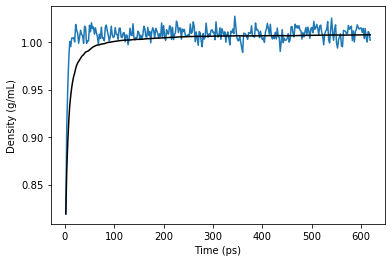

In [44]:

data = pd.read_csv(f"scalars_{n_molecules[1]}API_{api_cid[0]}_{n_molecules[2]}water_NPT.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

In [ ]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()